In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/cfrm523/Final_project')
from datetime import datetime

<ipython-input-1-22a1a3745f8b>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Mounted at /content/drive


Note: This final project is building off the original paper, which was replicated. \

Title: Constructing Cointegrated Cryptocurrency Portfolios for Statistical Arbitrage \
Authors: Tim Leung, Hung Nguyen

## Complete summary of hypotheses and tests for all components of the strategy (overall strategy theory, indicators, signal process, rules)

### Summary of strategy:

The original proposal objective was to identify prime stat-arb trading hours for Cryptocurrencies. This makes the inherent assumption that the cointegration strategy is profitable, and we are looking for hours of the day in which there are most cointegrated relationships. Once we find a period of most cointegrated relationships, trading of the strategy would be done within that window. The assets being tested were originally BTC, ETH, LTC, BCH, and XRP. However, this had to change to BTC, ETH, LTC, and SOL due to data quality issues on the minute scale. Just as in the original paper spreads consisiting of varying combinations of the available assets were traded. \

Through the process this objective changed in a few ways. Originally I was to split the project into 2 parts. Part 1 being finding a two hour window of time that had the most cointegrated relationships between assets. Part 2 was to  backtest the cointegration strategy on the optimal times found in part 1. \

Working through the project I found this methodology to be flawed in a few ways. The largest flaw was the assumption that the cointegration trading strategy was profitable. Some spreads are profitable! But that vanishes when you add a reasonable commission of 0.1% per transaction. I also found the need for splitting into 2 parts redundant. Optimizing the strategy with the objective for maximizing net profit, while ajusting the parameters of time of day to trade, and window of time to trade essentially combines the previously stated parts together. \

So going forward the strategy being tested is the cointegrated relationship between the assets BTC, ETH, LTC, and SOL. Adding to the the original signal of crossing upper/lower bounds of cointegrated relationships would be a signal from machine learning forecast. Once a boundary is crossed, we only enter the trade if a seperate ML forecast of the spread is in the direction of mean reversion. Moving forward the traditional cointegration strategy will be compared against itself with the added signal of ML forecast.


### Our indicators:

- Cointegration: Verifying stationarity and establishing upper and lower bounds
  - Augmented Dickey Fuller (ADF)
  - Philiphs Peron (PP)
  - (KPSS)
- Machine Learning price forecast
  - Each asset will have a neural network trained to predict t+60 (minutes) price

### Signal process and rules:

Cointegration: \
Once a cointegrated relationship is identified the signal of buying and selling is dependent on the spread crossing the lower or upper boundary. This boundary wil be dependent on the sigma, which will be a parameter to optimize for just as in the original paper. \

Machine Learning: \
Spreads will be calculated based on each NN asset price forecast and used for sizing in trade. Example: If spread crosses lower boundary (we want to buy spread) and our spread forecast of t+1 is in the direction of mean reversion, we buy 2 units of the spread rather than one. The strategy is still cointegration, but we use ML for confidence in mean reversion through sizing.

# Our constraints, benchmarks, and objectives of the strategy

Constraints: \
- Stop loss of 10%
- Trailing stop loss of 5%
- Close out trades at later defined period of time
- Cointegration model is based on history lookback window
- Buying and Selling of one Unit of defined spread
- Entering and exiting trade occurs:
  - Stoped out
  - Reaching the other boundary, example: buy 1 unit of spread at lower boundary, exit trade once spread reacheds the upper boundary.

Objective:
- Maximize Net Profit
- When optimizing for parameters: history lookback, trading window, and sigma values, all optimized based on Maximizing Net Profit.


Benchmark:
- The original cointegration strategy will be used as the benchmark.
- Rhe cointegration strategy + ML is the contender

# Our Data

- Strategy is based on minute data collected from 3/1/24 to 4/30/24 (2 months of data)
- Assets include: BTC, ETH, LTC, SOL
- All data obtained from Coinbase API
- For the ML features matrix, RSI, and pct returns of the minute data are also calculated

In [117]:
data = pd.read_csv('crypto_mar_april.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.drop('Unnamed: 0', axis=1)

df = data.loc[data['date'] >= datetime(2024,3,1,0,0,0)]
df = df.loc[df['date'] <= datetime(2024,3,1,12,0,0)]
df = df.drop_duplicates()
df = df.sort_values(by='date')
df = df.reset_index(drop=True)

df.head(4)

,date,ticker,open,high,low,close,volume
0,2024-03-01,BTC-USD,61179.03,61240.13,61162.83,61240.13,67.244532
1,2024-03-01,LTC-USD,79.99,80.23,79.99,80.23,473.582634
2,2024-03-01,SOL-USD,125.74,126.14,125.68,126.08,1108.448844
3,2024-03-01,ETH-USD,3341.78,3344.53,3340.15,3343.95,164.428233


# Indicators, test indicators separately from the strategy

Indicator 1: Cointegration upper and lower thresholds
- Applying the two step method per spread, we define a upper and lower bound defined by a sigma away from the mean in each direction.


Indicator 2: ML 60 minute forward forecast
- Once spread has crossed either upper or lower boundary from the defined cointegrated relationship, ML model is triggered to forecast 60 minutes ahead.
- Model is only run for predictions when cointegration boundaries are crossed.

Testing of these indicators seperately are done in results.

# Signal process, test signal process separately from the overall strategy

In [113]:
!pip install arch
from arch.unitroot import ADF
from arch.unitroot import PhillipsPerron
from arch.unitroot import KPSS
from sklearn.linear_model import LinearRegression
data = pd.read_csv('crypto_mar_april.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.drop('Unnamed: 0', axis=1)

df = data.loc[data['date'] >= datetime(2024,3,1,0,0,0)]
df = df.loc[df['date'] <= datetime(2024,3,1,12,0,0)]
df = df.drop_duplicates()
df = df.sort_values(by='date')
df = df.reset_index(drop=True)

btc = df.loc[df['ticker']=='BTC-USD']
btc = btc.reset_index(drop=True)
btc = btc.set_index('date')

eth = df.loc[df['ticker']=='ETH-USD']
eth = eth.reset_index(drop=True)
eth = eth.set_index('date')

ltc = df.loc[df['ticker']=='LTC-USD']
ltc = ltc.reset_index(drop=True)
ltc = ltc.set_index('date')

spread = pd.concat([btc['close'], eth['close'], ltc['close']], axis=1)
spread.columns = ['BTC', 'ETH', 'LTC']
diff_spread = spread.diff()

tickers = ['BTC', 'ETH', 'LTC']
for i in tickers:
  print(f'ADF {i} : {ADF(spread[i].diff().dropna()).pvalue}')
  print(f'Phillips Perron {i}: {PhillipsPerron(spread[i].diff().dropna()).pvalue}')
  print(f'KPSS {i}: {KPSS(spread[i].diff().dropna()).pvalue}')

lin_model = LinearRegression()
X = spread.drop('BTC', axis=1)
y = np.array(spread['BTC'])
lin_model.fit(X,y)

coef = np.array([1] + list(-1*lin_model.coef_))
print("coefficients: ", coef)
print("intercept: ", lin_model.intercept_)

ADF BTC : 0.0
Phillips Perron BTC: 0.0
KPSS BTC: 0.8014388295028906
ADF ETH : 0.0
Phillips Perron ETH: 0.0
KPSS ETH: 0.7962983160499207
ADF LTC : 9.216253748417669e-21
Phillips Perron LTC: 0.0
KPSS LTC: 0.07677680498885443
coefficients:  [  1.         -17.07767596  46.483788  ]
intercept:  7623.439888223496


Like in the paper replication we test the once differenced asset prices for stationarity. ADF and PP null hypothesis of non-stationarity are all rejected above, and KPSS null hypothesis of stationary is accepted for all 3 assets.

Our coefficients:  [  1.         -17.07767596  46.483788  ]

[]

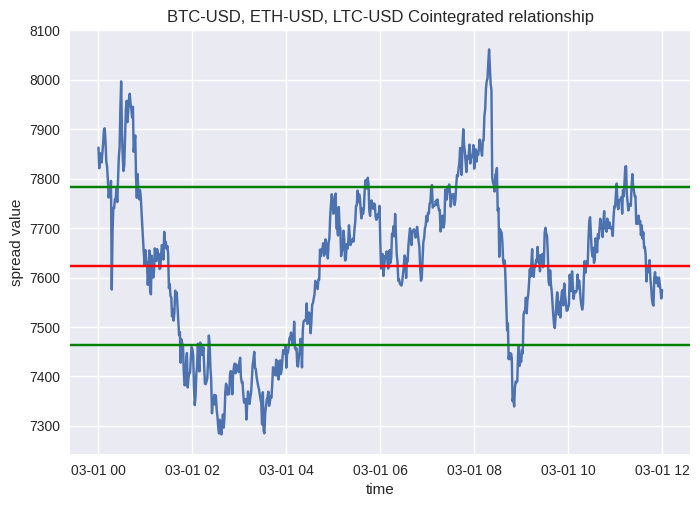

In [114]:
#spread.set_index('date', inplace=True)
spread['spread'] = spread.dot(coef)

plt.plot(spread.index, spread['spread'])
plt.axhline(y=spread['spread'].mean(), color='r', linestyle='-', label='Horizontal Line at E[spread]')
plt.axhline(y=spread['spread'].mean() + spread['spread'].std(), color='g', linestyle='-', label='UL-Bound')
plt.axhline(y=spread['spread'].mean() - spread['spread'].std(), color='g', linestyle='-')
plt.title("BTC-USD, ETH-USD, LTC-USD Cointegrated relationship")
plt.xlabel('time')
plt.ylabel('spread value')
plt.plot()

We see from the image above a cointegrated relationship between the assets BTC, ETH, and LTC over 12 hours.

Signal 1: Using Cointegration\
Hypothetical Cointegrated Relationship from the calculations above: $S_t = 1 BTC_t - 17 ETH_t + 46LTC_t$
- A buy signal is triggered when spread value crosses lower bound from cointegrated relationship.
  - We want to go Long the spread
    - +1 unit of $S_t$ = Buy 1 BTC, Sell 17 ETH, 46 LTC
- A sell signal is triggered when the spread value crosses the upper bound from the cointegrated relationship.
  - We want to go Short the spread
    - -1 unit of $S_t$ = Sell 1 BTC, Buy 17 ETH, sell 46 LTC

Signal 2: Using Machine Learning \
Disclaimer: Signal 2 is only triggered when Signal 1 is triggered \
We follow the same hypothetical cointegrated relationship from above. \
- The objective is to forecast what value the spread will be 60 minutes ahead, this helps us as we hope that it would be a reassuring signal that the spread is headed in the direction of reversion.
- A Sequential Neural Network has been trained on each specific Crypto Currency (BTC, ETH, LTC, SOL)
- Each asset is forecasted individually
- The Spread value 60 minutes ahead is calculated using individual asset forecasts 60 minutes ahead.
- Example Forecast: $S_{t+60}$ = 1 $BTC_{t+60} - 17 ETH_{t+60} + 46 LTC_{t+60}$

# Describe rule process, test rules incrementally

The rules of the strategy are simillar as the original paper replication. \
1. We enter once a upper or lower boundary is crossed.
2. We exit once the opposite upper or lower boundary is crossed.
3. What changes is we now only enter once we have confirmation from the ML forecast, stating that the spread is moving in the direction of mean-reversion 60 minutes ahead.

We test the rules imcrementaly by running two analysis.
1. Traditional trading of the Cointegration strategy.
2. The above strategy with the added ML signal.

# Assess optimization of parameters

Parameters available for optimization:
- History lookback window
  - This is the amount of bars looking back for each asset to apply the two-step method to.
  - Example: value of 4 would entail that BTC, ETH, LTC, SOL each will all have the last 240 closing prices (4*60).
  - This is an essential parameter because it defines the cointegrated relationship, and thus the entry and exit points for trading.
- Window of trading
  - This value is what period of time is the strategy allowed to trade (starting at 00:00:00 UTC).
  - Example value of 8 would mean the strategy can trade from 00:00:00 to 08:00:00
- Sigma value
  - This sets how far the upper and lower boundary is from the established spreads mean
  - Example: value of 3 would mean an upper boundary of adding $3\sigma$ to the mean $\mu$ of the cointegrated spread. And oppositely 3$\sigma$ would be subtracted from the mean for defining the lower boundary.
  - This parameter is essential, especially dealing with comissions. A smaller $\sigma$ might capture less profit which can easily be diminished once commissions are introduced.

#Apply walk forward analysis, discuss choice of objective function and impact on parameter choice

Walk forward analysis will be implemented on optimizing for the $\sigma$ value.

The objective function will be Total Net Profit. \

The process of walk forward analysis is to minimize overfitting of the parameters being optimized. \

Implementation: Rolling window\
$\sigma$ = [1,1.5,2,2.5,3,3.5,4,4.5,5] \
- These values will all be backtested in the training window.
- The "winner" ($\sigma$ value which maximized the objective function) will be used as the parameter $\sigma$ on the test set. This continues untill the full time length is finished.


# Assess Overfitting

There is opportunity for overfitting on the training set especially in regards to parameters history lookback, and window of trading. This is because the entirety of March data was used when backtesting each spread once per parameter value. There is less opportunity for overfitting on the parameter of sigma as it was obtained by a robust walk forward analysis.

ML models maybe prone to overfitting as well. Though the training and validation data seem to be well on the test set in March, performance is likely to vary on the full testing of April. These graphs are provided after the results section.

# Extend the analysis with other asset classes, additional similar techniques, or more sophisticated models

This process can be implemented on essentially any asset class. Pairs trading is quite common, I know this because most of the cohorts presentations were on the topic.

Adding sophistication: \
- Sizing based on ML forecast.
- If the forecasting accuracy of each asset is accurate, we may want to add size onto the trade in the future. Maybe measure a slope of the forecasted spread value and score it appropriately.
- Use ML forecast for volatility.
  - Dynamically adjust the stop/loss or trailing stop/loss based on the volatility forecast.

Applying this same process along with the same assets using the Copula, and Distance method would be very interesting.

## General process of the project

Assets: BTC, ETH, LTC, SOL \

1. We trade the cointegration strategy
  - Standard for optimization
    - Train: March (3/1/24 - 3/30/24)
    - Trade only from 04:00:00 to 08:00:00
    - All trades closed out after 08:00:00
    - Stop/Loss = 0.15
    - Trailing Stop/Loss = 0.05
    -  $σ$ = 3

2. Optimize for parameters on the standard above
  - History lookback (1,2,3,...24)
  - Window of trading (1,2,3,...24)
  - $\sigma$ = [1,1.5,2,2.5,3,3.5,4,4.5,5]

3. Tain the ML
  - March
  - 60 features per Close price, RSI, minute return for each asset
  - Our model will Forecast 60 minutes ahead

4. We test on April
  - Use optimized parameters from March
  - Test on Cointegrated strategy only
    - Get results for cointegrated strat
  - Test on Cointegrated strategy + ML added
    - Get results for cointegrated + ML strat

6. Conclusion
  - Which is better? Does ML help?


# Optimizing parameters in the month of March

History Lookback and Trading Window: \
- History lookback is the amount of bars used to formulate our cointegrated relationship.
- Trading Window is the window of time trades will be made.

Disclaimer: \
These two parameters were optimized using the training period of March entirely. Optimizing Sigma uses the walk forward analysis.

### Optimizing History Lookback

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

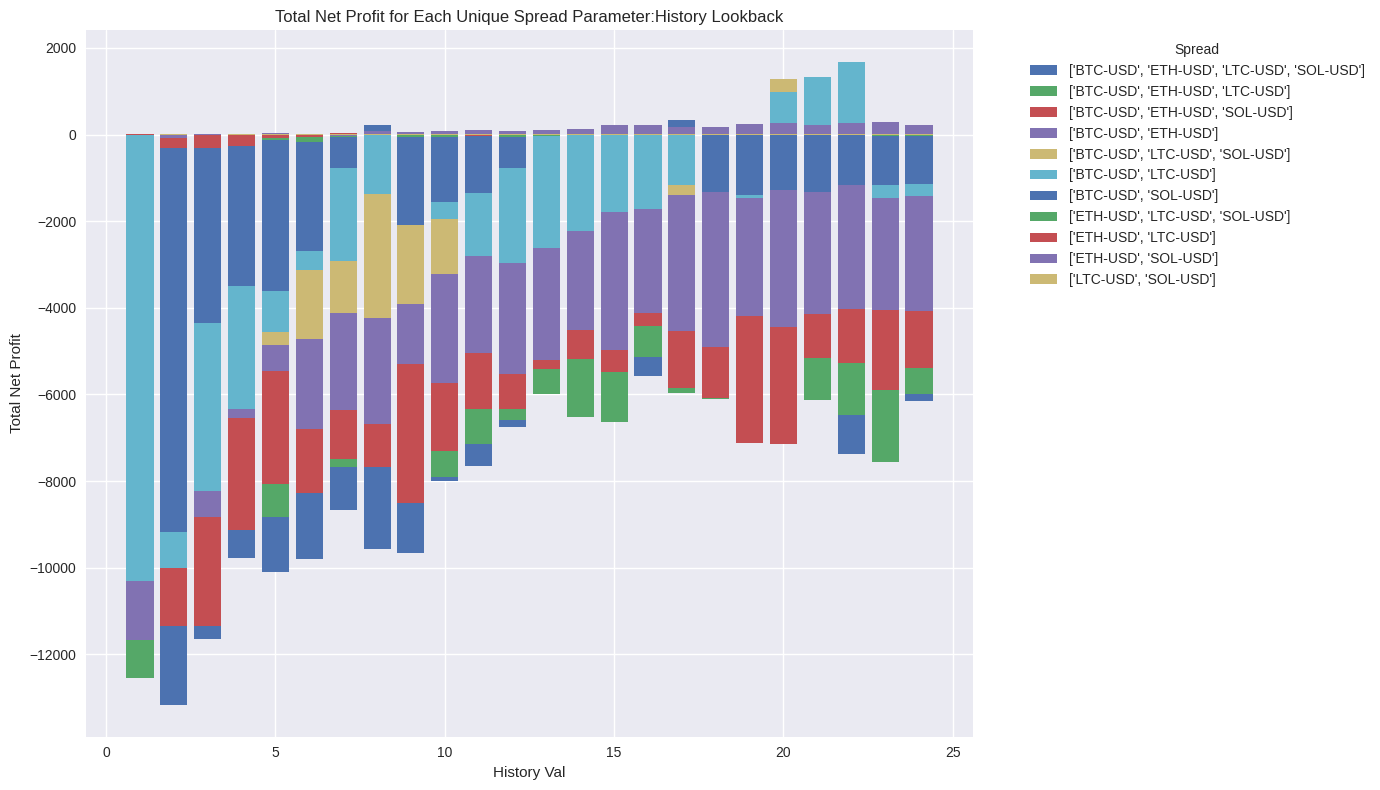

In [ ]:
df = pd.read_csv('Optimize_results/optimizing_historyBar_parameter_FINAL.csv')
df = df.drop(columns=['Unnamed: 0'])
# Sort the original DataFrame by 'spread' and 'Total Net Profit'
sorted_df = df.sort_values(by=['spread', 'history_val'], ascending=[True, True])
sorted_df = sorted_df.reset_index(drop=True)
sorted_df.head(23)
unique_spreads = sorted_df['spread'].unique()

# Create a larger figure
plt.figure(figsize=(14, 8))

# Plot Total Net Profit for each unique spread
for spread in unique_spreads:
    spread_df = sorted_df[sorted_df['spread'] == spread]
    plt.bar(spread_df['history_val'], spread_df['Total Net Profit'], label=str(spread))

# Add labels and legend
plt.xlabel('History Val')
plt.ylabel('Total Net Profit')
plt.title('Total Net Profit for Each Unique Spread Parameter:History Lookback')
plt.grid(True)

# Position legend outside the plot
plt.legend(title='Spread', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

We choose the history lookback to be set at 21 hours, as 3 spreads are profitable with the non-profitable spreads looking to be at a local minima.

### Optimizing Time Window for trading

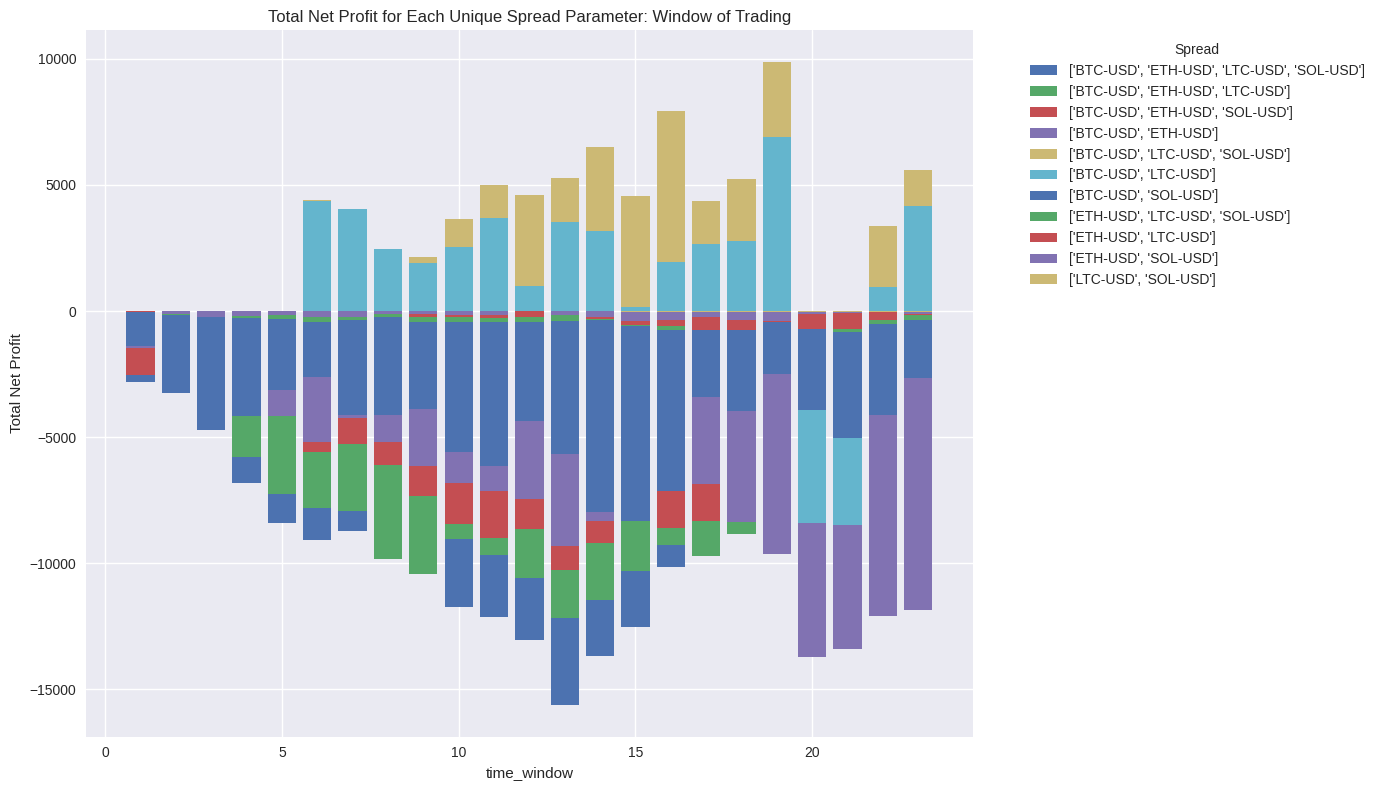

In [ ]:
df = pd.read_csv('Optimize_results/optimizing_time_window_FINAL.csv')
df = df.drop(columns=['Unnamed: 0'])
# Sort the original DataFrame by 'spread' and 'Total Net Profit'
sorted_df = df.sort_values(by=['spread', 'time_window_val'], ascending=[True, True])
sorted_df = sorted_df.reset_index(drop=True)
unique_spreads = sorted_df['spread'].unique()
# Create a larger figure
plt.figure(figsize=(14, 8))

# Plot Total Net Profit for each unique spread
for spread in unique_spreads:
    spread_df = sorted_df[sorted_df['spread'] == spread]
    plt.bar(spread_df['time_window_val'], spread_df['Total Net Profit'], label=str(spread))

# Add labels and legend
plt.xlabel('time_window')
plt.ylabel('Total Net Profit')
plt.title('Total Net Profit for Each Unique Spread Parameter: Window of Trading')
plt.grid(True)

# Position legend outside the plot
plt.legend(title='Spread', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

Looking at the results we see that a good window of trading parameter can be identified at 18. Though this value doesn't yield the highest Net Profit, it does show two spreads to be profitable. Most of the spreads are not profitable but at a trading window of 18 hours it shows the other spreads loose less money.

## Optimizing Sigma Walk Forward Analysis

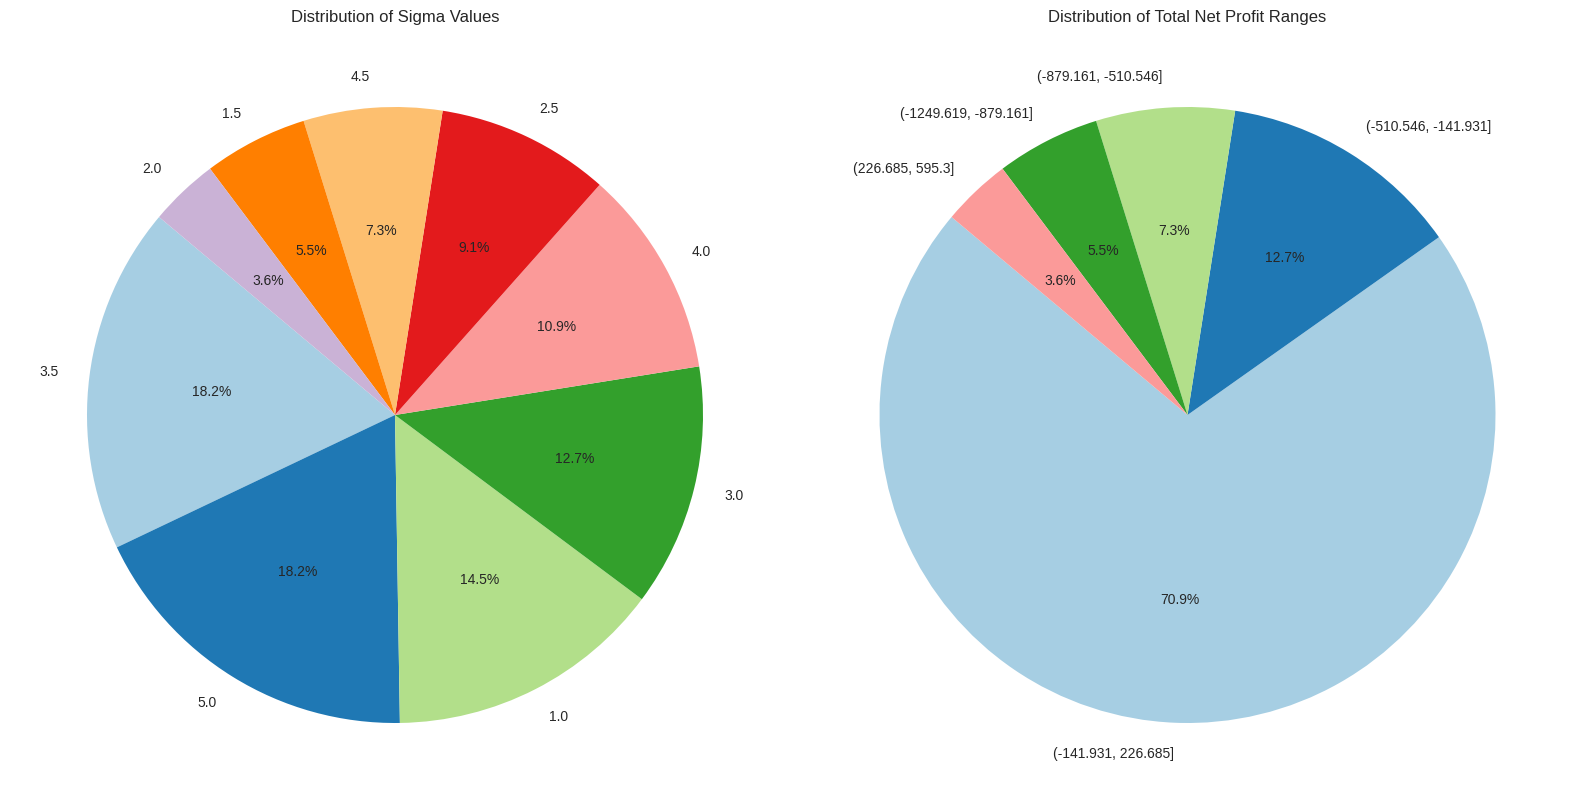

In [ ]:
# Aggregating data to create pie charts
df = pd.read_csv('Optimize_results/results_sigma_val_WF.csv')
sigma_val_counts = df['sigma_val'].value_counts()
profit_groups = pd.cut(df['Total Net Profit'], bins=5).value_counts()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Pie chart for sigma_val distribution
axes[0].pie(sigma_val_counts, labels=sigma_val_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
axes[0].set_title('Distribution of Sigma Values')

# Pie chart for Total Net Profit distribution
axes[1].pie(profit_groups, labels=profit_groups.index.astype(str), autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
axes[1].set_title('Distribution of Total Net Profit Ranges')

plt.tight_layout()
plt.show()

In [52]:
df.head()

,Unnamed: 0,spread,train_start,train_end,test_start,test_end,sigma_val,Total Net Profit
0,0,"['BTC-USD', 'SOL-USD']",2024-03-01,2024-03-06,2024-03-06,2024-03-11,1.0,283.455708
1,1,"['BTC-USD', 'SOL-USD']",2024-03-06,2024-03-11,2024-03-11,2024-03-16,4.5,0.000000
2,2,"['BTC-USD', 'SOL-USD']",2024-03-11,2024-03-16,2024-03-16,2024-03-21,1.0,197.776943
3,3,"['BTC-USD', 'SOL-USD']",2024-03-16,2024-03-21,2024-03-21,2024-03-26,1.0,-539.855661
4,4,"['BTC-USD', 'SOL-USD']",2024-03-21,2024-03-26,2024-03-26,2024-03-31,3.0,-285.735404


In [53]:
df.tail()

,Unnamed: 0,spread,train_start,train_end,test_start,test_end,sigma_val,Total Net Profit
50,50,"['BTC-USD', 'ETH-USD', 'LTC-USD']",2024-03-01,2024-03-06,2024-03-06,2024-03-11,4.5,0.000000
51,51,"['BTC-USD', 'ETH-USD', 'LTC-USD']",2024-03-06,2024-03-11,2024-03-11,2024-03-16,4.0,-504.723926
52,52,"['BTC-USD', 'ETH-USD', 'LTC-USD']",2024-03-11,2024-03-16,2024-03-16,2024-03-21,5.0,-120.872601
53,53,"['BTC-USD', 'ETH-USD', 'LTC-USD']",2024-03-16,2024-03-21,2024-03-21,2024-03-26,5.0,0.000000
54,54,"['BTC-USD', 'ETH-USD', 'LTC-USD']",2024-03-21,2024-03-26,2024-03-26,2024-03-31,3.5,0.000000


### A description of the process
Walk Forward analysis was applied
- Time Frame: 3/1/24 to 3/31/24
- Training and Testing increments: 5 days each
- Applied to all 11 spreads
- $\sigma$ values: [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
- Objective: maximize Total Net Profit

Summary: The walk forward method was utilized to find optimal parameters for sigma and reduce the likelihood of overfitting. A rolling window of 5 days were moved through for the entire month of March. \

Example of the processs of the Walk Forward method for spread 1: \
1. Train: 3/1/24-3/6/24
  - Run seperate backtests for all values of sigma [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
2. A winner is chosen (and documented) from the above sigma values, based on Maximum "Total Net Profit"
3. That sigma value is then used to backtest over the testing period: 3/6/24-3/11/24
4. That "Total Net Profit" is documented.
5. At the end an analysis can be done to find the ideal sigma value which occurs most frequently through the whole walk forward analysis.

Disclaimer: Though some sigma values in the table above show a "Total Net Profit" of 0 on the testing period (meaning no trades). This is not the case in the training period as backtests which resulted in 0 trades for sigma values were discarded.

### Picking our Sigma
Through analysis we conclude that a sigma value of 3.5 is ideal. Looking at the full data there isn't much profitability to begin with. And the most occuring sigma values that come out of the training subsets are 3.5, and 5. However, a closer examination of those values we see that a sigma of 5 results in no trades with a Total Net Profit being \$0. So an optimal sigma value of 3.5 is chosen.

# Results seperately backtesting our two signals
1. Cointegration
2. Machine Learning Forecast

## Cointegration
We use the optimized parameters obtained from the previous section. Backtesting was done for both $\sigma$ values of 3.5 and 5, with the lookback window being 21 hours, and window of trading per day being 18 hours (from mindnight to 6 pm UTC). \

We use just cointegration with no ML involved to see how our strategy played out in the month of April.

## Backtest Results: optimized parameters and no machine learning

Lookback Window: 21 \
Window of Trading: 18 \
Sigma value: 3.5

In [ ]:
df_opt_params = pd.read_csv('April_results_opt_params_3_rounded.csv')
df_opt_params

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10
0,spread,"['BTC-USD', 'ETH-USD']","['BTC-USD', 'LTC-USD']","['BTC-USD', 'SOL-USD']","['ETH-USD', 'LTC-USD']","['ETH-USD', 'SOL-USD']","['LTC-USD', 'SOL-USD']","['BTC-USD', 'ETH-USD', 'LTC-USD']","['BTC-USD', 'ETH-USD', 'SOL-USD']","['BTC-USD', 'LTC-USD', 'SOL-USD']","['ETH-USD', 'LTC-USD', 'SOL-USD']","['BTC-USD', 'ETH-USD', 'LTC-USD', 'SOL-USD']"
1,Total Net Profit,-6561.26,-11747.76,-5821.17,-685.87,-450.58,0.52,-5418.58,-4090.38,-5236.59,-800.47,-4293.39
2,Gross Profit,14988.70,8299.51,18440.17,887.15,1039.31,36.68,18174.76,24561.78,20971.75,1281.31,33241.89
3,Gross Loss,-21549.96,-20047.27,-24261.34,-1571.08,-1489.90,-36.16,-23593.34,-28652.17,-26208.34,-2081.79,-37535.28
4,Percent Profitable,45.45,37.50,45.24,32.08,41.67,55.77,44.00,47.44,43.75,45.56,43.75
5,Winning Trades,20,15,19,17,20,29,33,37,42,41,63
6,Losing Trades,24,25,23,35,28,23,42,41,54,49,81
7,Avg. Trade Net Profit,-149.12,-293.69,-138.60,-12.94,-9.39,0.01,-72.25,-52.44,-54.55,-8.89,-29.82
8,Avg. Winning Trade,749.44,553.30,970.54,52.19,51.97,1.26,550.75,663.83,499.33,31.25,527.65
9,Avg. Losing Trade,-897.92,-801.89,-1054.84,-44.89,-53.21,-1.57,-561.75,-698.83,-485.34,-42.49,-463.40


## Trying the second best Sigma for the month of April:
Lookback Window: 21 \
Window of Trading: 18 \
Sigma value: 5

In [ ]:
df_opt_params_sigma5 = pd.read_csv('April_results_opt_params_sigma5_rounded.csv')
df_opt_params_sigma5

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10
0,spread,"['BTC-USD', 'ETH-USD']","['BTC-USD', 'LTC-USD']","['BTC-USD', 'SOL-USD']","['ETH-USD', 'LTC-USD']","['ETH-USD', 'SOL-USD']","['LTC-USD', 'SOL-USD']","['BTC-USD', 'ETH-USD', 'LTC-USD']","['BTC-USD', 'ETH-USD', 'SOL-USD']","['BTC-USD', 'LTC-USD', 'SOL-USD']","['ETH-USD', 'LTC-USD', 'SOL-USD']","['BTC-USD', 'ETH-USD', 'LTC-USD', 'SOL-USD']"
1,Total Net Profit,-4815.05,-8154.97,-6157.89,-442.54,-419.18,-1.85,-8511.96,-9475.33,-4755.06,-543.22,-7460.86
2,Gross Profit,5474.94,6145.91,3105.87,466.55,488.13,15.44,8795.10,9406.07,11337.81,601.67,17642.49
3,Gross Loss,-10289.99,-14300.88,-9263.76,-909.09,-907.31,-17.29,-17307.06,-18881.40,-16092.87,-1144.89,-25103.35
4,Percent Profitable,45.00,42.86,40.91,36.67,40.63,45.00,35.90,46.67,41.67,38.89,42.86
5,Winning Trades,9,12,9,11,13,9,14,21,25,21,36
6,Losing Trades,11,16,13,19,19,11,25,24,35,33,48
7,Avg. Trade Net Profit,-240.75,-291.25,-279.90,-14.75,-13.10,-0.09,-218.26,-210.56,-79.25,-10.06,-88.82
8,Avg. Winning Trade,608.33,512.16,345.10,42.41,37.55,1.72,628.22,447.91,453.51,28.65,490.07
9,Avg. Losing Trade,-935.45,-893.80,-712.60,-47.85,-47.75,-1.57,-692.28,-786.72,-459.80,-34.69,-522.99


In [ ]:
df_ml_sigma5

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10
0,spread,"['BTC-USD', 'ETH-USD']","['BTC-USD', 'LTC-USD']","['BTC-USD', 'SOL-USD']","['ETH-USD', 'LTC-USD']","['ETH-USD', 'SOL-USD']","['LTC-USD', 'SOL-USD']","['BTC-USD', 'ETH-USD', 'LTC-USD']","['BTC-USD', 'ETH-USD', 'SOL-USD']","['BTC-USD', 'LTC-USD', 'SOL-USD']","['ETH-USD', 'LTC-USD', 'SOL-USD']","['BTC-USD', 'ETH-USD', 'LTC-USD', 'SOL-USD']"
1,Total Net Profit,-4371.48,-8052.72,-5645.05,-436.28,-385.06,-1.51,-5988.72,-7706.61,-7013.70,-505.05,-5736.94
2,Gross Profit,5605.76,6297.69,2919.75,471.56,425.41,13.21,6173.76,8229.99,7182.94,437.13,13711.04
3,Gross Loss,-9977.24,-14350.41,-8564.80,-907.84,-810.47,-14.72,-12162.48,-15936.60,-14196.64,-942.18,-19447.98
4,Percent Profitable,44.44,42.86,45.45,36.67,42.86,44.44,40.00,47.62,35.19,37.50,39.71
5,Winning Trades,8,12,10,11,12,8,12,20,19,18,27
6,Losing Trades,10,16,12,19,16,10,18,22,35,30,41
7,Avg. Trade Net Profit,-242.86,-287.60,-256.59,-14.54,-13.75,-0.08,-199.62,-183.49,-129.88,-10.52,-84.37
8,Avg. Winning Trade,700.72,524.81,291.97,42.87,35.45,1.65,514.48,411.50,378.05,24.29,507.82
9,Avg. Losing Trade,-997.72,-896.90,-713.73,-47.78,-50.65,-1.47,-675.69,-724.39,-405.62,-31.41,-474.34


We see that the results were almost all profitable for either case of sigma (3.5, 5). \
Drawdown does generally decrease for a sigma value of 5. This can be the result of a decrease in trading as signals are less likely to be triggered with such a high sigma value.

## Backtest Results with our final optimized parameters and Machine Learning signal month of April


Lookback Window: 21 \
Window of Trading: 18 \
Sigma value: 3.5

In [ ]:
df_ml_sigma3_5 = pd.read_csv('April_results_ML_sigma3_5_rounded.csv')
df_ml_sigma3_5

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10
0,spread,"['BTC-USD', 'ETH-USD']","['BTC-USD', 'LTC-USD']","['BTC-USD', 'SOL-USD']","['ETH-USD', 'LTC-USD']","['ETH-USD', 'SOL-USD']","['LTC-USD', 'SOL-USD']","['BTC-USD', 'ETH-USD', 'LTC-USD']","['BTC-USD', 'ETH-USD', 'SOL-USD']","['BTC-USD', 'LTC-USD', 'SOL-USD']","['ETH-USD', 'LTC-USD', 'SOL-USD']","['BTC-USD', 'ETH-USD', 'LTC-USD', 'SOL-USD']"
1,Total Net Profit,-5114.23,-11684.61,-4411.51,-623.72,-518.45,3.11,-3585.26,-3839.62,-3659.34,-876.88,-2768.67
2,Gross Profit,12157.19,8244.05,14676.64,914.16,927.00,30.55,18035.29,21569.72,21161.13,925.55,27950.00
3,Gross Loss,-17271.42,-19928.66,-19088.15,-1537.88,-1445.45,-27.45,-21620.55,-25409.34,-24820.47,-1802.43,-30718.68
4,Percent Profitable,38.89,40.00,50.00,32.69,43.18,54.55,49.28,48.61,43.33,44.00,44.53
5,Winning Trades,14,16,17,17,19,24,34,35,39,33,57
6,Losing Trades,22,24,17,35,25,20,35,37,51,42,71
7,Avg. Trade Net Profit,-142.06,-292.12,-129.75,-11.99,-11.78,0.07,-51.96,-53.33,-40.66,-11.69,-21.63
8,Avg. Winning Trade,868.37,515.25,863.33,53.77,48.79,1.27,530.45,616.28,542.59,28.05,490.35
9,Avg. Losing Trade,-785.06,-830.36,-1122.83,-43.94,-57.82,-1.37,-617.73,-686.74,-486.68,-42.91,-432.66


In [ ]:
df_ml_sigma5 = pd.read_csv('April_results_ML_5_rounded.csv')
df_ml_sigma5

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10
0,spread,"['BTC-USD', 'ETH-USD']","['BTC-USD', 'LTC-USD']","['BTC-USD', 'SOL-USD']","['ETH-USD', 'LTC-USD']","['ETH-USD', 'SOL-USD']","['LTC-USD', 'SOL-USD']","['BTC-USD', 'ETH-USD', 'LTC-USD']","['BTC-USD', 'ETH-USD', 'SOL-USD']","['BTC-USD', 'LTC-USD', 'SOL-USD']","['ETH-USD', 'LTC-USD', 'SOL-USD']","['BTC-USD', 'ETH-USD', 'LTC-USD', 'SOL-USD']"
1,Total Net Profit,-4371.48,-8052.72,-5645.05,-436.28,-385.06,-1.51,-5988.72,-7706.61,-7013.70,-505.05,-5736.94
2,Gross Profit,5605.76,6297.69,2919.75,471.56,425.41,13.21,6173.76,8229.99,7182.94,437.13,13711.04
3,Gross Loss,-9977.24,-14350.41,-8564.80,-907.84,-810.47,-14.72,-12162.48,-15936.60,-14196.64,-942.18,-19447.98
4,Percent Profitable,44.44,42.86,45.45,36.67,42.86,44.44,40.00,47.62,35.19,37.50,39.71
5,Winning Trades,8,12,10,11,12,8,12,20,19,18,27
6,Losing Trades,10,16,12,19,16,10,18,22,35,30,41
7,Avg. Trade Net Profit,-242.86,-287.60,-256.59,-14.54,-13.75,-0.08,-199.62,-183.49,-129.88,-10.52,-84.37
8,Avg. Winning Trade,700.72,524.81,291.97,42.87,35.45,1.65,514.48,411.50,378.05,24.29,507.82
9,Avg. Losing Trade,-997.72,-896.90,-713.73,-47.78,-50.65,-1.47,-675.69,-724.39,-405.62,-31.41,-474.34


## Conclusion: comparing the results of No and Yes ML!

Sigma 3.5: \
All of the spreads remain unprofitable, with [LTC-USD, SOL-USD] being slightly larger than $0. \
However, 9 out of 11 spreads improved "Total Net Profit" and "Drawdown" with the ML forecasting signal! The Spreads which didn't improve were [ETH-USD, SOL-USD] and [ETH-USD, LTC-USD, SOL-USD].

Sigma 5: \
Again, all of the spreads remain nearly unprofitable as above.
However, 10 out of 11 spreads improved in "Total Net Profit", while 9 out of 11 improved in "Drawdown" while 1 spread remaining the same.

When optimizing for parameters in March there were 3 spreads that were clearly profitable. Those 3 spreads were not profitable whatsoever in April.

In clonclusion we see that adding a machine learning signal does in fact help increase profitability (even though the spreads are not profitable). When conducting the original backtests, comissions were set to 0.1%, this was done because it was stated on several exchanges online. However towards the end of this project a classmate Jiachen had explained to me how RobinHood does not charge commision for trading crypto. With that knowledge, some of these spreads will be profitable as they were just hovering near \$0 in "Total Net Profit".

#Example of how the BTC ML model was made

The code below shows how the Forecasting model for BTC-USD was created. Our strategy trades spreads, therefore we created a seperate ML model for each asset. Once trained, it was then saved, and loaded onto backtrader when backtesting all spreads. \

All ML models use the last 60 minutes of feature data to predict the 60th minute forecast price for that particular asset. \

The process of building the model is the same for other assets ETH, LTC, and SOL (just with their own pricing data).

About the Deep Neural Net:
- 6 hidden layers, 100 neurons each, activation function "relu"
- normalized input features
- one dense layer
- HeNorm() used as regularization technique
- trained 50 epochs with a mse loss function

Feature data: \
- last 60 close prices
- last 60 RSI values
- last 60 returns

Output value: \
- forecasted price 60 minutes ahead for that asset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/cfrm523/Final_project')
from datetime import datetime
import tensorflow as tf

<ipython-input-19-5adfed062f48>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('crypto_mar_april.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.drop('Unnamed: 0', axis=1)

df = data.loc[data['date'] >= datetime(2024,3,1,0,0,0)]
df = df.loc[df['date'] <= datetime(2024,3,30,0,0,0)]
df = df.drop_duplicates()
df = df.sort_values(by='date')
df = df.reset_index(drop=True)

btc = df.loc[df['ticker']=='BTC-USD']
btc = btc.reset_index(drop=True)
btc = btc.set_index('date')

In [ ]:
def calculate_rsi(prices, window=60):
    # Calculate the price differences
    delta = prices.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=60).mean()
    avg_loss = loss.rolling(window=window, min_periods=60).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

#add in RSI
btc['RSI'] = calculate_rsi(btc['close'])
btc['returns'] = btc['close'].pct_change()
btc = btc.dropna()

#function to split X
def ts_split(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    return X

#function to split y for n-days (value_target) ahead
def ts_split_y(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    y = np.array([ts[idx + feature_steps + target_steps - 1]
                  for idx in range(n_obs)])
    return y

value_features = 60############ Use the last hour of pricing data to predict the next hour
value_target = 60###############
################################
btc_close = ts_split(np.array(btc['close']), feature_steps = value_features, target_steps = value_target)
btc_rsi = ts_split(np.array(btc['RSI']), feature_steps = value_features, target_steps = value_target)
btc_ret = ts_split(np.array(btc['returns']), feature_steps = value_features, target_steps = value_target)

y_btc = ts_split_y(np.array(btc['close']), feature_steps = value_features, target_steps = value_target)

#try with all
combined_array = np.stack((btc_close, btc_rsi, btc_ret), axis=1)
X = combined_array


# Determine the size of the validation set
train_idx = round(len(X)*0.8)
X_train_full= X[:train_idx] ## all same for each model

#test data for X and y targets
X_test= X[train_idx:]
y_test_btc = y_btc[train_idx:]

val_idx = round(train_idx * 0.1)  # 10% of the training set
train_idx_final = train_idx - val_idx

# Split the training data into training and validation sets
X_train = X_train_full[:train_idx_final]
X_val = X_train_full[train_idx_final:train_idx]

#train and validation for targets
y_train_btc = y_btc[:train_idx_final]
y_val_btc = y_btc[train_idx_final:train_idx]

#reshape and convert all into pandas series
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_train_reshaped = pd.DataFrame(X_train_reshaped)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_val_reshaped = pd.DataFrame(X_val_reshaped)

y_train_btc = pd.DataFrame(y_train_btc)
y_val_btc = pd.DataFrame(y_val_btc)

#reshape  test
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_test_reshaped = pd.DataFrame(X_test_reshaped)

y_test_btc_reshaped = y_test_btc.reshape(y_test_btc.shape[0], -1)
y_test_btc_reshaped = pd.DataFrame(y_test_btc_reshaped)

def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

from tensorflow.keras.initializers import HeNormal
#try BTC model
reset_session()
tf.random.set_seed(42)
initializer = HeNormal()
norm_layer = tf.keras.layers.Normalization(input_shape=X_train_reshaped.shape[1:])
norm_layer.adapt(X_train_reshaped)
model_BTC = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_BTC.compile(loss="mse", optimizer=optimizer)
history_BTC = model_BTC.fit(X_train_reshaped, y_train_btc, epochs=50, validation_data=(X_val_reshaped, y_val_btc))
#mse_test = model_BTC.evaluate(X_test_reshaped, y_test_btc)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/50
936/936 [==============================] - 8s 5ms/step - loss: 475453056.0000 - val_loss: 57923616.0000
Epoch 2/50
936/936 [==============================] - 3s 4ms/step - loss: 18347442.0000 - val_loss: 3964239.5000
Epoch 3/50
936/936 [==============================] - 3s 4ms/step - loss: 4176683.2500 - val_loss: 3053206.0000
Epoch 4/50
936/936 [==============================] - 5s 5ms/step - loss: 2137348.5000 - val_loss: 1617274.7500
Epoch 5/50
936/936 [==============================] - 4s 5ms/step - loss: 1514317.6250 - val_loss: 763419.7500
Epoch 6/50
936/936 [==============================] - 3s 4ms/step - loss: 1287880.2500 - val_loss: 628099.5625
Epoch 7/50
936/936 [==============================] - 3s 4ms/step - loss: 1049621.3750 - val_loss: 489588.1875
Epoch 8/50
936/936 [==============================] - 5s 5ms/step - loss: 937871.9375 - val_loss: 1224586.5000
Epoch 9/50
936/936 [==============================] - 4s 4ms/step - loss: 1031562.8750 - val_loss: 57367

260/260 [==============================] - 1s 3ms/step
RMSE model 460.30103886304585


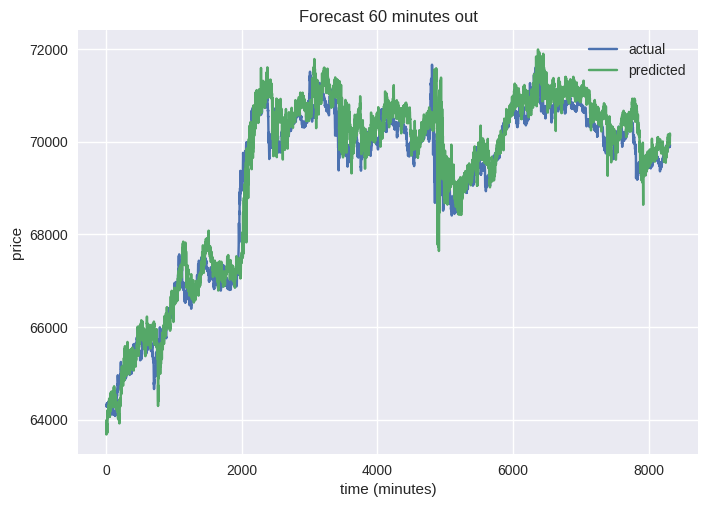

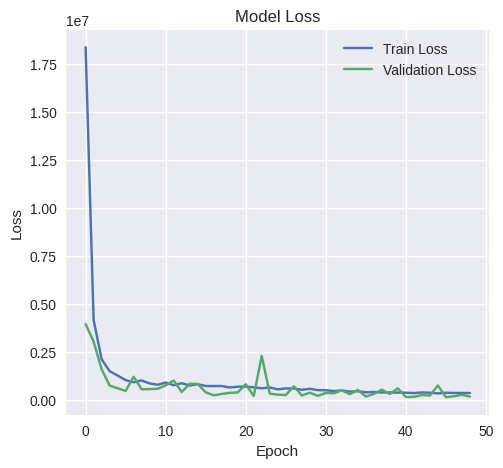

In [ ]:
from sklearn.metrics import mean_squared_error

X_new = X_test_reshaped[:]
y_pred = model_BTC.predict(X_new) #we are predicting n-stepsahead now

plt.plot(y_test_btc, label="actual") #y_test is already the n-days out values
plt.plot(y_pred, label='predicted')
plt.xlabel('time (minutes)')
plt.ylabel('price')
plt.legend()
plt.title(f'Forecast {value_target} minutes out')

mse = mean_squared_error(y_test_btc, y_pred.ravel())

# Plotting the loss
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_BTC.history['loss'][1:], label='Train Loss')
plt.plot(history_BTC.history['val_loss'][1:], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

print(f"RMSE model {np.sqrt(mse)}")

Curves look quite good on second graph. We see that the gap between train and validation are minimal suggesting a lack of overfitting. RMSE value is about \$460 which isn't too bad considering BTC-USD was trading around \$60,000 in the month of April.

# Code of the Backtest

Below is the code used for backtesting strategy with ML.

``` python
import pandas as pd
import numpy as np
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/cfrm523/Final_project')
from datetime import datetime
import tensorflow as tf

data = pd.read_csv('crypto_mar_april.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.drop('Unnamed: 0', axis=1)

df = data.loc[data['date'] >= datetime(2024,4,1,0,0,0)]
df = df.loc[df['date'] <= datetime(2024,4,30,0,0,0)]
df = df.drop_duplicates()
df = df.reset_index(drop=True)

btc = df.loc[df['ticker']=='BTC-USD']
btc = btc.sort_values('date')
btc = btc.reset_index(drop=True)
btc = btc.set_index('date')

eth = df.loc[df['ticker']=='ETH-USD']
eth = eth.sort_values('date')
eth = eth.reset_index(drop=True)
eth = eth.set_index('date')

ltc = df.loc[df['ticker']=='LTC-USD']
ltc = ltc.sort_values('date')
ltc = ltc.reset_index(drop=True)
ltc = ltc.set_index('date')

sol = df.loc[df['ticker']=='SOL-USD']
sol = sol.sort_values('date')
sol = sol.reset_index(drop=True)
sol = sol.set_index('date')

```

``` python
from arch.unitroot import ADF
from arch.unitroot import KPSS
from arch.unitroot import PhillipsPerron
from sklearn.linear_model import LinearRegression

def strat_creation(datas, spread):
  # Create a Stratey
  class spread_strat(bt.Strategy):
      params = (
          ('history', 21*60),
          ('rsi_window', 60)
      )

      def log(self, txt, dt=None):
          ''' Logging function for this strategy '''
          if dt is None:
              # Access the datetime index from the current line in the data series
              dt = self.datas[0].datetime.datetime(0)

          # Check if dt is still a float (the internal representation for Backtrader), and convert it if needed
          if isinstance(dt, float):
              # Convert backtrader float date to datetime
              dt = bt.num2date(dt)

          # Format datetime object to string
          dt_str = dt.strftime('%Y-%m-%d %H:%M:%S')
          print('%s, %s' % (dt_str, txt))

      def log_trade(self, action, size, asset, executed_price, status):
        self.trade_logs.append({
                'Date': self.datas[0].datetime.datetime(0).strftime('%Y-%m-%d %H:%M:%S'),
                'Action': action,
                'Size': size,
                'Asset': asset,
                'executed_price': executed_price,
                'status': status
            })
        return

      def close_all_positions(self):
        count = 0
        round_val = 5
        names = ['BTC', 'ETH', 'LTC', 'SOL']
        for data in self.datas:
          position = self.getposition(data)
          if position.size != 0:
              #action = 'SELL' if position.size > 0 else 'BUY'
              #self.log_trade(action, round(-1*position.size, round_val), data.close[0], names[count])
              self.order = self.close(data)
          count+=1
        return


      def calc_ml_forecast(self, datas):
        forecast = 60
        if datas == 2:
          series0 = pd.Series(self.data0.get(size=forecast+1))
          series1 = pd.Series(self.data1.get(size=forecast+1))
          series0_diff = series0.diff().dropna()  # taking the diff of both series
          series1_diff = series1.diff().dropna()
          data0_ret = series0.pct_change()
          data0_ret = data0_ret.dropna()
          data1_ret = series1.pct_change()
          data1_ret = data1_ret.dropna()
          combined_array = np.concatenate((self.data0.get(size=forecast),
                                     self.data0_rsi.get(size=forecast),
                                      data0_ret))
          X0 = combined_array.flatten().reshape(1,-1)

          combined_array = np.concatenate((self.data1.get(size=forecast),
                                     self.data1_rsi.get(size=forecast),
                                      data1_ret))
          X1 = combined_array.flatten().reshape(1,-1)
          predict0 = self.ml_model_0.predict(X0)[0][0]
          predict1 = self.ml_model_1.predict(X1)[0][0]
          #print(f'predictions: btc:{self.data0.get(size=1)}, pred:{predict0}, ltc:{self.data1.get(size=1)}, pred:{predict1}')

          ml_forecast = predict0  + self.coefficients[1]*predict1

        if datas == 3:
          series0 = pd.Series(self.data0.get(size=forecast+1))
          series1 = pd.Series(self.data1.get(size=forecast+1))
          series2 = pd.Series(self.data2.get(size=forecast+1))
          series0_diff = series0.diff().dropna()  # taking the diff of both series
          series1_diff = series1.diff().dropna()
          series2_diff = series2.diff().dropna()
          data0_ret = series0.pct_change()
          data0_ret = data0_ret.dropna()
          data1_ret = series1.pct_change()
          data1_ret = data1_ret.dropna()
          data2_ret = series2.pct_change()
          data2_ret = data2_ret.dropna()
          combined_array = np.concatenate((self.data0.get(size=forecast),
                                     self.data0_rsi.get(size=forecast),
                                      data0_ret))
          X0 = combined_array.flatten().reshape(1,-1)
          combined_array = np.concatenate((self.data1.get(size=forecast),
                                     self.data1_rsi.get(size=forecast),
                                      data1_ret))
          X1 = combined_array.flatten().reshape(1,-1)
          combined_array = np.concatenate((self.data2.get(size=forecast),
                                     self.data2_rsi.get(size=forecast),
                                      data2_ret))
          X2 = combined_array.flatten().reshape(1,-1)
          predict0 = self.ml_model_0.predict(X0)[0][0]
          predict1 = self.ml_model_1.predict(X1)[0][0]
          predict2 = self.ml_model_2.predict(X2)[0][0]

          #print(f'predictions: A1:{self.data0.get(size=1)}, pred:{predict0}, A2:{self.data1.get(size=1)}, pred:{predict1} A3:{self.data2.get(size=1)}, pred:{predict2}')

          ml_forecast = predict0  + self.coefficients[1]*predict1 + self.coefficients[2]*predict2

        if datas == 4:
          series0 = pd.Series(self.data0.get(size=forecast+1))
          series1 = pd.Series(self.data1.get(size=forecast+1))
          series2 = pd.Series(self.data2.get(size=forecast+1))
          series3 = pd.Series(self.data3.get(size=forecast+1))
          series0_diff = series0.diff().dropna()  # taking the diff of both series
          series1_diff = series1.diff().dropna()
          series2_diff = series2.diff().dropna()
          series3_diff = series3.diff().dropna()
          data0_ret = series0.pct_change()
          data0_ret = data0_ret.dropna()
          data1_ret = series1.pct_change()
          data1_ret = data1_ret.dropna()
          data2_ret = series2.pct_change()
          data2_ret = data2_ret.dropna()
          data3_ret = series3.pct_change()
          data3_ret = data3_ret.dropna()
          combined_array = np.concatenate((self.data0.get(size=forecast),
                                     self.data0_rsi.get(size=forecast),
                                      data0_ret))
          X0 = combined_array.flatten().reshape(1,-1)
          combined_array = np.concatenate((self.data1.get(size=forecast),
                                     self.data1_rsi.get(size=forecast),
                                      data1_ret))
          X1 = combined_array.flatten().reshape(1,-1)
          combined_array = np.concatenate((self.data2.get(size=forecast),
                                     self.data2_rsi.get(size=forecast),
                                      data2_ret))
          X2 = combined_array.flatten().reshape(1,-1)
          combined_array = np.concatenate((self.data3.get(size=forecast),
                                     self.data3_rsi.get(size=forecast),
                                      data3_ret))
          X3 = combined_array.flatten().reshape(1,-1)
          predict0 = self.ml_model_0.predict(X0)[0][0]
          predict1 = self.ml_model_1.predict(X1)[0][0]
          predict2 = self.ml_model_2.predict(X2)[0][0]
          predict3 = self.ml_model_3.predict(X3)[0][0]

          #print(f'predictions: A1:{self.data0.get(size=1)}, pred:{predict0}, A2:{self.data1.get(size=1)}, pred:{predict1} A3:{self.data2.get(size=1)}, pred:{predict2}, A4:{self.data3.get(size=1)}, pred:{predict3}')

          ml_forecast = predict0  + self.coefficients[1]*predict1 + self.coefficients[2]*predict2 + self.coefficients[3]*predict3
        return ml_forecast
      def __init__(self):
        for i in range(len(spread)):
          print(spread[i])
          data_name = f'data{i}'
          rsi_name = f'data{i}_rsi'
          setattr(self, data_name, self.datas[i].close)
          setattr(self, rsi_name, bt.indicators.RSI(self.datas[i].close, period=self.params.rsi_window))
          model_name = f"ml_model_{i}"
          if spread[i] == 'BTC-USD':
              model = tf.keras.models.load_model('btc_model_intraday')
          elif spread[i] == 'ETH-USD':
              model = tf.keras.models.load_model('eth_model_intraday')
          elif spread[i] == 'LTC-USD':
              model = tf.keras.models.load_model('ltc_model_intraday')
          elif spread[i] == 'SOL-USD':
              model = tf.keras.models.load_model('sol_model_intraday')
          else:
              model = None  # Handle case where spread[i] is not recognized
          if model is not None:
            setattr(self, model_name, model)
            print(f'spread {spread[i]}, model added {model_name}')
        #constant for strat
        self.cointegrated = False
        self.upper_bound = None
        self.lower_bound = None
        self.model_built = False
        self.coefficients = None
        self.mean_ = None
        self.sigma = 5
        self.spread_val = None
        self.model_date = self.datas[0].datetime.datetime(0)
        self.trade_logs = []
        self.order = None
        self.stop_loss_constant = 0.15
        self.stop_loss_spread_val = None
        self.postion_type = None
        self.trailing_spread_val = None
        self.trailing_constant = 0.05

        return

      def create_series_tickers(self, datas):
        if datas == 2:
          series1 = pd.Series(self.data0.get(size=self.params.history))
          series2 = pd.Series(self.data1.get(size=self.params.history))
          series1_diff = series1.diff().dropna()  # taking the diff of both series
          series2_diff = series2.diff().dropna()
          tickers = [series1_diff, series2_diff]
          series_tickers = [series1, series2]
          data1_ret = series1.pct_change()
          data1_ret = data1_ret.dropna()
          data2_ret = series2.pct_change()
          data2_ret = data2_ret.dropna()
        if datas == 3:
          series1 = pd.Series(self.data0.get(size=self.params.history))
          series2 = pd.Series(self.data1.get(size=self.params.history))
          series3 = pd.Series(self.data2.get(size=self.params.history))
          series1_diff = series1.diff().dropna()  # taking the diff of both series
          series2_diff = series2.diff().dropna()
          series3_diff = series3.diff().dropna()
          tickers = [series1_diff, series2_diff, series3_diff]
          series_tickers = [series1, series2, series3]
        if datas == 4:
          series1 = pd.Series(self.data0.get(size=self.params.history))
          series2 = pd.Series(self.data1.get(size=self.params.history))
          series3 = pd.Series(self.data2.get(size=self.params.history))
          series4 = pd.Series(self.data3.get(size=self.params.history))
          series1_diff = series1.diff().dropna()  # taking the diff of both series
          series2_diff = series2.diff().dropna()
          series3_diff = series3.diff().dropna()
          series4_diff = series4.diff().dropna()
          tickers = [series1_diff, series2_diff, series3_diff, series4_diff]
          series_tickers = [series1, series2, series3, series4]
        return tickers, series_tickers

      def create_model(self, series_tickers):
        lin_model = LinearRegression()
        X = np.column_stack([s.values for s in series_tickers[1:]])
        Y = series_tickers[0].values
        lin_model.fit(X,Y)  # Fit model to the differenced data
        self.coefficients = [1] + list(-1*lin_model.coef_)
        spread = series_tickers[0]
        for i in range(1,len(self.coefficients)):
          spread += self.coefficients[i] * series_tickers[i]
        self.mean_ = np.mean(spread)#mean
        self.upper_bound = self.mean_ + self.sigma*np.std(spread)
        self.lower_bound = self.mean_ - self.sigma*np.std(spread)
        self.model_built = True
        return

      def stationarity_test(self, tickers):
        for i in range(len(tickers)): #iterate through series and check for stationarity on the DIFFERENCED
          adf = ADF(tickers[i])
          pp = PhillipsPerron(tickers[i])
          kpss = KPSS(tickers[i])
          if adf.pvalue < 0.05 and pp.pvalue < 0.05 and kpss.pvalue > 0.10: #check weather pass all the tests
            self.cointegrated = True
          else:
            self.cointegrated = False
        return

      def calc_spread_val(self, datas):
        if datas == 2:
          self.spread_val = self.data0[0] + self.data1[0]*self.coefficients[1]
        elif datas == 3:
          self.spread_val = self.data0[0] + self.data1[0]*self.coefficients[1] + self.data2[0]*self.coefficients[2]
        elif datas == 4:
          self.spread_val = self.data0[0] + self.data1[0]*self.coefficients[1] + self.data2[0]*self.coefficients[2] + self.data3[0]*self.coefficients[3]

        return

      def clear_vars(self):
        self.cointegrated = False
        self.upper_bound = None
        self.lower_bound = None
        self.model_built = False
        self.coefficients = None
        self.mean_ = None
        self.spread_val = None
        self.stop_loss_spread_val = None
        self.position_type = None
        self.trailing_spread_val = None
        return

      def check_stop_loss(self):
        if self.spread_val < self.stop_loss_spread_val and self.position_type == "LONG":
          self.log(f'Long position stopped out: {self.spread_val}')
          self.close_all_positions()
          print('in stop')
          self.clear_vars()
        elif self.spread_val > self.stop_loss_spread_val and self.position_type == "SHORT":
          self.log(f'Short position stopped out: {self.spread_val}')
          self.close_all_positions()
          print('in stop')
          self.clear_vars()
        elif self.spread_val < self.trailing_spread_val and self.position_type == "LONG":
          self.log(f'Trailing Long position stopped out: {self.spread_val}')
          self.close_all_positions()
          print('in trailing stop')
          self.clear_vars()
        elif self.spread_val > self.trailing_spread_val and self.position_type == "SHORT":
          self.log(f'Trailing Short position stopped out: {self.spread_val}')
          self.close_all_positions()
          print('in trailing stop')
          self.clear_vars()
        #update trailing stop loss
        if self.position_type == "LONG":
          self.trailing_spread_val = self.spread_val - self.spread_val * self.trailing_constant if self.spread_val > 0 else self.spread_val + self.spread_val * self.trailing_constant
        if self.position_type == "SHORT":
          self.trailing_spread_val = self.spread_val + self.spread_val * self.trailing_constant if self.spread_val > 0 else self.spread_val - self.spread_val * self.trailing_constant
        return

      def next(self):
        round_val = 5
        current_datetime = self.datas[0].datetime.datetime(0)
        current_hour = current_datetime.hour
        current_minute = current_datetime.minute
        tickers, series_tickers = self.create_series_tickers(datas) #get the datas in pandas series
        if 0 <= current_hour < 18: #this is inherently rolling
          if len(self.data0) >= self.params.history: #check if there is sufficient data for looking back
            #######################################
            if self.model_built == False: #we only build the model once for the time period
              self.stationarity_test(tickers)
              #we want to define the model once and trade on that model for the time period
              if self.cointegrated == True and self.model_built == False:
                self.create_model(series_tickers)
                self.calc_spread_val(datas)
                #self.log(f'Upper bound {self.upper_bound}, Lower bound {self.lower_bound}, spread val: {self.spread_val}, coefs:{self.coefficients}')
            #if the model is already built we trade now
            elif self.model_built == True:
              #calculate the spread value
              self.calc_spread_val(datas)
              #identify if not in position
              if not self.position:
                #get into a long spread *************** ADD ML
                if self.spread_val < self.lower_bound:
                  #FORECAST THE SPREAD PRICE
                  ml_forecast = self.calc_ml_forecast(datas)
                  if abs(ml_forecast - self.mean_) < abs(self.spread_val - self.mean_):
                    #self.log(f'spread mean: {self.mean_}, spread value: {self.spread_val}, ml forecast: {ml_forecast}')
                    self.order = self.buy(self.datas[0], size=1)
                    #self.log_trade('BUY', 1, self.datas[0][0], 'BTC')
                    for i in range(1,len(self.coefficients)):
                      if self.coefficients[i] > 0:
                        self.order = self.buy(self.datas[i], size=self.coefficients[i])
                      elif self.coefficients[i] < 0:
                        self.order = self.sell(self.datas[i], size = self.coefficients[i])
                    self.stop_loss_spread_val = self.spread_val - self.spread_val * self.stop_loss_constant if self.spread_val > 0 else self.spread_val + self.spread_val * self.stop_loss_constant
                    self.trailing_spread_val = self.stop_loss_spread_val
                    self.position_type = 'LONG'
                    #self.log(f'Buy Created:{self.spread_val}, stopout: {self.stop_loss_spread_val}')
                #get into a short *************** ADD ML
                elif self.spread_val > self.upper_bound:
                  ml_forecast = self.calc_ml_forecast(datas)
                  if abs(ml_forecast - self.mean_) < abs(self.spread_val - self.mean_):
                    #self.log(f'spread mean: {self.mean_}, spread value: {self.spread_val}, ml forecast: {ml_forecast}')
                    self.order = self.sell(self.datas[0], size=1)
                    #self.log_trade('SELL', -1, self.datas[0][0], 'BTC')
                    for i in range(1,len(self.coefficients)):
                      if self.coefficients[i] > 0:
                        self.order = self.sell(self.datas[i], size = self.coefficients[i])
                      elif self.coefficients[i] < 0:
                        self.order = self.buy(self.datas[i], size = self.coefficients[i])
                    self.stop_loss_spread_val = self.spread_val + self.spread_val * self.stop_loss_constant if self.spread_val > 0 else self.spread_val - self.spread_val * self.stop_loss_constant
                    self.trailing_spread_val = self.stop_loss_spread_val
                    self.position_type = 'SHORT'
                    #self.log(f'Sell Created:{self.spread_val}, stopout: {self.stop_loss_spread_val}')

              #identify if in position
              elif self.position:
                position_size = self.position.size
                #check if currently in long and hit our exit (upper boundary) position size is inherently BTC which is in direction of spread
                if position_size > 0 and self.spread_val > self.upper_bound:
                    self.log('Close existing Long position, %.2f' % self.spread_val)
                    self.close_all_positions()
                #check if currently in short and hit our exit (lower boundary)
                elif position_size < 0 and self.spread_val < self.lower_bound:
                    self.log('Close existing Short position, %.2f' % self.spread_val)
                    self.close_all_positions()
                self.check_stop_loss()

        #reset our model after 6 and close out any positions
        if current_hour == 18 and current_minute == 0: #always close out trades
          self.clear_vars()
          if self.position:
            self.log("Closing all positions: ")
            self.close_all_positions()

      def notify_order(self, order):
        # Check if an order has been completed
        action = None
        executed_price = None
        size = None
        status = None
        if order.status in [order.Submitted, order.Accepted]:
          return
        if order.status in [order.Completed]:
          if order.isbuy():
            #self.log(f'BUY Executed,  asset:{order.data._name}, size:{order.executed.size}, execution price: {order.executed.price}, Cost: {order.executed.value},')
            executed_price = order.executed.price
            size = order.executed.size
            asset = order.data._name
            action = "BUY"
            status = "Complete"
          elif order.issell():
            #self.log(f'BUY Executed,  asset:{order.data._name}, size:{order.executed.size}, execution price: {order.executed.price}, Cost: {order.executed.value},')
            executed_price = order.executed.price
            size = order.executed.size
            asset = order.data._name
            action = "SELL"
            status = "Complete"

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f'Order Canceled/Margin/Rejected')
            status = "REJECTED"
            action = None
          # Write down: no pending order
        self.log_trade(action, size, asset, executed_price, status)
        self.order = None
        return

      def stop(self):
        # Close all positions at the end of the strategy
        self.log('Closing all positions at the end of the backtest')
        #if self.position:
        #  self.close_all_positions()
        #  print('need to close')

        if len(self.trade_logs) > 0:
          self.trade_logs_df = pd.DataFrame(self.trade_logs)
          self.trade_logs_df['value'] = self.trade_logs_df['Size']*self.trade_logs_df['executed_price']
        #print(self.trade_logs_df)
        #self.trade_logs_df.to_csv('output.csv')
        return

  return spread_strat
```

``` python
from itertools import combinations

cryptos = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'SOL-USD']
# Collect all combinations from size 2 to the length of the list
all_combinations = []
for r in range(2, len(cryptos)+1):
    all_combinations.extend(list(combinations(cryptos, r)))

spreads = []
# Print all combinations
for combo in all_combinations:
    spreads.append(list(combo))

metrics = {
        'spread': [],
        'Total Net Profit': [],
        'Gross Profit': [],
        'Gross Loss': [],
        'Percent Profitable': [],
        'Winning Trades': [],
        'Losing Trades': [],
        'Avg. Trade Net Profit': [],
        'Avg. Winning Trade': [],
        'Avg. Losing Trade': [],
        'Ratio Avg. Win:Avg. Loss': [],
        'Largest Winning Trade': [],
        'Largest Losing Trade': [],
        'Max. Consecutive Winning Trades': [],
        'Max. Consecutive Losing Trades': [],
        'Avg. Bars in Total Trades': [],
        'Avg. Bars in Winning Trades': [],
        'Avg. Bars in Losing Trades': [],
        'Max. Drawdown': []
    }

spreads = [['BTC-USD', 'SOL-USD']] #simple run
for i in spreads:
  cerebro = bt.Cerebro()
  TestStrategy = strat_creation(len(i),i)
  cerebro.addstrategy(TestStrategy)
  if 'BTC-USD' in i:
    btc_bt = bt.feeds.PandasData(dataname=btc)
    cerebro.adddata(btc_bt, name='BTC')
  if 'ETH-USD' in i:
    eth_bt = bt.feeds.PandasData(dataname=eth)
    cerebro.adddata(eth_bt, name='ETH')
  if 'LTC-USD' in i:
    ltc_bt = bt.feeds.PandasData(dataname=ltc)
    cerebro.adddata(ltc_bt, name='LTC')
  if 'SOL-USD' in i:
    sol_bt = bt.feeds.PandasData(dataname=sol)
    cerebro.adddata(sol_bt, name='SOL')

  initial_cash = 1000000
  cerebro.broker.set_cash(initial_cash)
  cerebro.broker.setcommission(commission=0.001)  # 0.1% commission per trade

  # Add analyzers
  cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="trade_analyzer")
  cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe_ratio", riskfreerate=0.0)
  cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
  cerebro.addanalyzer(bt.analyzers.Returns, _name="returns")
  # Run backtest
  results = cerebro.run()
  strategy = results[0]

  # Extract metrics from analyzers
  trade_analyzer = strategy.analyzers.trade_analyzer.get_analysis()
  sharpe_ratio = strategy.analyzers.sharpe_ratio.get_analysis()
  drawdown = strategy.analyzers.drawdown.get_analysis()
  returns = strategy.analyzers.returns.get_analysis()
  # Calculate custom metrics
  total_net_profit = cerebro.broker.getvalue() - initial_cash
  total_gross_profit = trade_analyzer.won.pnl.total
  total_gross_loss = trade_analyzer.lost.pnl.total
  total_number_trades = trade_analyzer.total.total
  percent_profitable = (trade_analyzer.won.total / trade_analyzer.total.total) * 100
  winning_trades = trade_analyzer.won.total
  losing_trades = trade_analyzer.lost.total
  avg_trade_net_profit = total_net_profit / trade_analyzer.total.total
  avg_winning_trade = trade_analyzer.won.pnl.average
  avg_losing_trade = trade_analyzer.lost.pnl.average
  ratio_avg_win_loss = avg_winning_trade/avg_losing_trade
  largest_winning_trade = trade_analyzer.won.pnl.max
  largest_losing_trade = trade_analyzer.lost.pnl.max
  max_consecutive_winning_trades = trade_analyzer.streak.won.longest
  max_consecutive_losing_trades = trade_analyzer.streak.lost.longest
  avg_bars_in_total_trades = trade_analyzer.len.total
  avg_bars_in_winning_trades = trade_analyzer.len.won.total
  avg_bars_in_losing_trades = trade_analyzer.len.lost.total
  max_drawdown = drawdown.max.moneydown

  metrics['spread'].append(i)
  metrics['Total Net Profit'].append(total_net_profit)
  metrics['Gross Profit'].append(total_gross_profit)
  metrics['Gross Loss'].append(total_gross_loss)
  metrics['Percent Profitable'].append(percent_profitable)
  metrics['Winning Trades'].append(winning_trades)
  metrics['Losing Trades'].append(losing_trades)
  metrics['Avg. Trade Net Profit'].append(avg_trade_net_profit)
  metrics['Avg. Winning Trade'].append(avg_winning_trade)
  metrics['Avg. Losing Trade'].append(avg_losing_trade)
  metrics['Ratio Avg. Win:Avg. Loss'].append(ratio_avg_win_loss)
  metrics['Largest Winning Trade'].append(largest_winning_trade)
  metrics['Largest Losing Trade'].append(largest_losing_trade)
  metrics['Max. Consecutive Winning Trades'].append(max_consecutive_winning_trades)
  metrics['Max. Consecutive Losing Trades'].append(max_consecutive_losing_trades)
  metrics['Avg. Bars in Total Trades'].append(avg_bars_in_total_trades)
  metrics['Avg. Bars in Winning Trades'].append(avg_bars_in_winning_trades)
  metrics['Avg. Bars in Losing Trades'].append(avg_bars_in_losing_trades)
  metrics['Max. Drawdown'].append(max_drawdown)

pd.DataFrame.from_dict(metrics).T

```

#Walkforward Analysis Code

``` python
import pandas as pd
import numpy as np
import backtrader as bt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from arch.unitroot import ADF
from arch.unitroot import KPSS
from arch.unitroot import PhillipsPerron
from sklearn.linear_model import LinearRegression
from itertools import combinations
import time
import concurrent.futures
import strategy_sigma as strat_create

def run_backtest(start, end, spread, sigma_val):
    print(start, end, spread, sigma_val)
    crypto_data = strat_create.get_data(filename, start, end)
    btc = crypto_data['BTC-USD']
    eth = crypto_data['ETH-USD']
    ltc = crypto_data['LTC-USD']
    sol = crypto_data['SOL-USD']

    cerebro = bt.Cerebro()
    TestStrategy = strat_create.strat_creation(len(spread), sigma_val) #create the strategy with sigma value
    cerebro.addstrategy(TestStrategy)
    if 'BTC-USD' in spread:
        btc_bt = bt.feeds.PandasData(dataname=btc)
        cerebro.adddata(btc_bt)
    if 'ETH-USD' in spread:
        eth_bt = bt.feeds.PandasData(dataname=eth)
        cerebro.adddata(eth_bt)
    if 'LTC-USD' in spread:
        ltc_bt = bt.feeds.PandasData(dataname=ltc)
        cerebro.adddata(ltc_bt)
    if 'SOL-USD' in spread:
        sol_bt = bt.feeds.PandasData(dataname=sol)
        cerebro.adddata(sol_bt)

    initial_cash = 1000000
    cerebro.broker.set_cash(initial_cash)
    cerebro.broker.setcommission(commission=0.001)

    results = cerebro.run()
    strategy = results[0]

    total_net_profit = cerebro.broker.getvalue() - initial_cash

    return total_net_profit


def walk_forward(start_date, end_date, period_length, spreads):
    #start 3/1, end 3/5
    #metrics
    metrics = {
        'spread': [], 'train_start': [], 'train_end': [], 'test_start': [], 'test_end': [],
        'sigma_val': [], 'Total Net Profit': []
    }
    sigma_vals = [1,1.5,2,2.5,3,3.5,4,4.5,5]
    #train start date
    train_start = start_date
    while train_start + timedelta(days=period_length*2) <= end_date:
        train_end = train_start + timedelta(days=period_length) #end of train date
        test_start = train_end #start of test date
        test_end = test_start + timedelta(days=period_length) #end of test start
        best_sigma = None
        best_profit = -float('inf')
        for sigma_val in sigma_vals: #iterate through the sigmas
            train_profit = run_backtest(train_start, train_end, spreads, sigma_val) #run backtest on the training data
            if train_profit > best_profit and train_profit != 0.0: #update best profit and best sigma
                best_profit = train_profit
                best_sigma = sigma_val
        test_profit = run_backtest(test_start, test_end, spreads, best_sigma) #run backtest on test data with best sigma from training run
        metrics['spread'].append(spreads)
        metrics['train_start'].append(train_start)
        metrics['train_end'].append(train_end)
        metrics['test_start'].append(test_start)
        metrics['test_end'].append(test_end)
        metrics['sigma_val'].append(best_sigma)
        metrics['Total Net Profit'].append(test_profit)
        
        train_start += timedelta(days=period_length)

    return pd.DataFrame(metrics)

filename = 'multi_process/crypto_mar_april.csv'

if __name__ == "__main__":
    filename = 'multi_process/crypto_mar_april.csv'
    start_date = datetime(2024, 3, 1, 0, 0)
    end_date = datetime(2024, 4, 1, 0, 0)
    period_length = 5
    #spreads = [['BTC-USD', 'LTC-USD', 'SOL-USD'], ['BTC-USD', 'ETH-USD']]
    cryptos = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'SOL-USD']
    all_combinations = []
    for r in range(2, len(cryptos) + 1):
        all_combinations.extend(list(combinations(cryptos, r)))

    spreads = []
    for combo in all_combinations:
        spreads.append(list(combo))
    #spreads = [['BTC-USD', 'ETH-USD', 'LTC-USD', 'SOL-USD']]
    start = time.perf_counter()
    metrics = {
        'spread': [], 'train_start': [], 'train_end': [], 'test_start': [], 'test_end': [],
        'sigma_val': [], 'Total Net Profit': []
    }
    error_list = []
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(walk_forward, start_date, end_date, period_length, spread) for spread in spreads]
        for future in concurrent.futures.as_completed(futures):
            try:
                result = future.result()
                for key in metrics:
                    metrics[key].extend(result[key])
            except Exception as e:
                print(f'Error: {e}')
                error_list.append(future)

    final = time.perf_counter()
    df = pd.DataFrame(metrics)
    print(df)

    print(f'Time duration: {round(final - start, 2)} seconds')
    df.to_csv('optimize_results/sigma/results_sigma_val_WF.csv')
    print(error_list)


```